<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

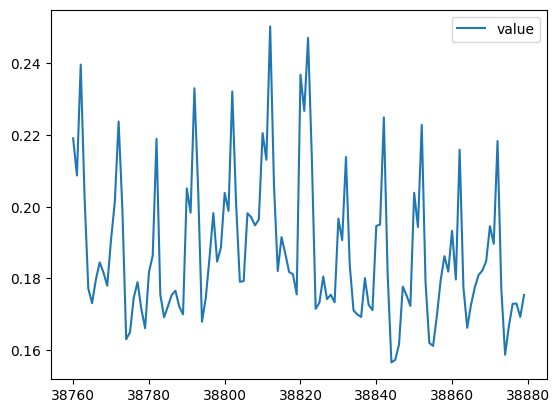

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 27
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_619285/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 65.69855304402218 %
smape 24.114112396076408 %
smape 10.11374056949253 %
smape 9.546812033792685 %
smape 9.32658632204198 %
smape 9.228950141553295 %
smape 9.126759747925558 %
smape 9.053376222911634 %
smape 9.087518715893316 %
smape 9.126076973234005 %
smape 9.077377902746896 %
smape 8.932044611513962 %
smape 8.947346632243597 %
smape 8.958544062766416 %
smape 8.891695200176963 %
smape 8.937776646854585 %
smape 8.944758954103929 %
smape 9.046683419517606 %
smape 9.01912124097696 %
smape 8.855084305008253 %
smape 8.82968847166028 %
smape 8.790000124632964 %
smape 8.903846414814218 %
smape 8.858215574894036 %
smape 8.729201779640906 %
smape 8.711764399419751 %
smape 8.751344946567079 %
smape 8.872384016799648 %
smape 8.857925247989202 %
smape 8.708005104410022 %
smape 8.733034406227675 %
smape 8.693193344954858 %
smape 8.761206197372653 %
smape 8.67621200387938 %
smape 8.66381516277093 %
smape 8.679481687688687 %
smape 8.60589928358619 %
smape 8.659194347105528 %
smape 8.662698916

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.14568567804508348 %
SMAPE 5.221134914758295 %
SMAPE 0.5037504387601075 %
SMAPE 0.35050070263969246 %
SMAPE 0.060077762685807556 %
SMAPE 0.7762944487863024 %
SMAPE 1.195057558015833 %
SMAPE 0.4371497569773055 %
SMAPE 0.5706512893473246 %
SMAPE 0.6816941082943231 %
SMAPE 0.9699640848985851 %
SMAPE 0.5089481309823896 %
SMAPE 0.09707621468987782 %
SMAPE 0.17436106061722967 %
SMAPE 0.797218820627677 %
SMAPE 1.1305981869154493 %
SMAPE 0.6161871699969197 %
SMAPE 2.855822740248186 %
SMAPE 0.6290820002855071 %
SMAPE 0.48940371998833143 %
SMAPE 3.6007077848644258 %
SMAPE 0.07034915334793368 %
SMAPE 2.1399342048780454 %
SMAPE 0.325111073001608 %
SMAPE 1.9794506207426823 %
SMAPE 2.5269816136609506 %
SMAPE 0.6495800182524363 %
SMAPE 0.748888743552925 %
SMAPE 0.99694726337475 %
SMAPE 0.07537849429627386 %
SMAPE 0.6149462092344038 %
SMAPE 0.6076960274835983 %
SMAPE 0.5936703634179139 %
SMAPE 0.3339434755034745 %
SMAPE 0.9054218940977989 %
SMAPE 0.6056036144254904 %
SMAPE 0.1895257664635963 %


SMAPE 0.6586927274202026 %
SMAPE 0.22041754561632843 %
SMAPE 0.2384599995029717 %
SMAPE 1.9410994617855977 %
SMAPE 0.12604840307722043 %
SMAPE 1.3164347420097329 %
SMAPE 0.13648012314115476 %
SMAPE 0.13323468408725603 %
SMAPE 0.5025853762094812 %
SMAPE 1.7048431151524708 %
SMAPE 1.089981987788633 %
SMAPE 1.3174447315541329 %
SMAPE 9.42731742124306 %
SMAPE 2.771069888403872 %
SMAPE 0.04261206009994112 %
SMAPE 1.8098317528456391 %
SMAPE 0.7050250685297215 %
SMAPE 1.2047375851288962 %
SMAPE 0.30078968719499244 %
SMAPE 0.5242456545602181 %
SMAPE 0.18525290424622654 %
SMAPE 0.12784656038274989 %
SMAPE 0.1643240344710648 %
SMAPE 0.29358774740830995 %
SMAPE 0.8618226067483192 %
SMAPE 0.6729081337907701 %
SMAPE 0.8094273700680219 %
SMAPE 0.4013438927977404 %
SMAPE 0.1678136817045015 %
SMAPE 2.702685190529337 %
SMAPE 2.608563308218436 %
SMAPE 0.5381824085416156 %
SMAPE 0.7513027799664087 %
SMAPE 0.44800419167586364 %
SMAPE 0.8998843447125182 %
SMAPE 0.5786986932216678 %
SMAPE 0.2069406365424129

SMAPE 0.5099629001199943 %
SMAPE 1.3479670297238044 %
SMAPE 0.9745197775555426 %
SMAPE 0.342627013858646 %
SMAPE 1.0449702499536215 %
SMAPE 0.6270236948348611 %
SMAPE 0.04108606911222523 %
SMAPE 0.14367758506796235 %
SMAPE 0.9153288367024288 %
SMAPE 0.24416090930708378 %
SMAPE 0.05946522693989209 %
SMAPE 0.05330073145705682 %
SMAPE 0.9840691708632221 %
SMAPE 0.3793033603897129 %
SMAPE 0.5748403309498826 %
SMAPE 1.3195719490067859 %
SMAPE 0.7387298381872824 %
SMAPE 0.5539809234887798 %
SMAPE 0.2589829731377904 %
SMAPE 0.6101484805367363 %
SMAPE 0.15636608389831963 %
SMAPE 1.0432487433445203 %
SMAPE 0.7324459588708123 %
SMAPE 0.7314789835072588 %
SMAPE 2.3984404762832128 %
SMAPE 0.8720198854025512 %
SMAPE 0.16471424197720808 %
SMAPE 0.6912036460316813 %
SMAPE 1.2433006373685203 %
SMAPE 0.08314146768498176 %
SMAPE 0.5573701814737433 %
SMAPE 0.26255914583657614 %
SMAPE 0.7075346020906181 %
SMAPE 0.11937456790474243 %
SMAPE 0.1572347038306816 %
SMAPE 0.37250367341584933 %
SMAPE 0.7391914580

SMAPE 0.9699306371767308 %
SMAPE 0.4376839404794736 %
SMAPE 0.4987730314023792 %
SMAPE 0.28720264953153674 %
SMAPE 0.1881442691301345 %
SMAPE 0.22442337816278268 %
SMAPE 0.16862281961584813 %
SMAPE 0.09305238077740796 %
SMAPE 0.07649467184057102 %
SMAPE 0.31087162120456924 %
SMAPE 0.37831258713231364 %
SMAPE 1.5814520810563406 %
SMAPE 0.3539767736710928 %
SMAPE 0.057675856789501274 %
SMAPE 0.11699713422444803 %
SMAPE 1.090410360126043 %
SMAPE 0.43196143015120475 %
SMAPE 0.5226504258986608 %
SMAPE 0.06876743471366353 %
SMAPE 0.10246208953640236 %
SMAPE 0.5339215917340425 %
SMAPE 0.6347184365877183 %
SMAPE 0.29518940160414786 %
SMAPE 0.13966019255212814 %
SMAPE 0.7451431067420344 %
SMAPE 1.1448862446500243 %
SMAPE 0.10315486425747622 %
SMAPE 0.20177916615739377 %
SMAPE 0.2433625887861126 %
SMAPE 0.2293207647790041 %
SMAPE 0.4007900711221737 %
SMAPE 0.22602405958969032 %
SMAPE 1.2441333684691926 %
SMAPE 0.18081873002574866 %
SMAPE 0.1673807330685122 %
SMAPE 0.3691086448811802 %
SMAPE 0.18

SMAPE 1.2855336359643843 %
SMAPE 0.0692414678987916 %
SMAPE 0.7098627926825429 %
SMAPE 0.38042140681227465 %
SMAPE 0.4522171361641085 %
SMAPE 0.9631918372306245 %
SMAPE 0.3241133536921552 %
SMAPE 0.3453745781912403 %
SMAPE 0.09202776154495496 %
SMAPE 0.20000826444629638 %
SMAPE 0.21364988074765282 %
SMAPE 0.10048058728636987 %
SMAPE 0.09191334142769847 %
SMAPE 0.777851295300934 %
SMAPE 1.1462674904469168 %
SMAPE 0.1275429759725739 %
SMAPE 0.34096137491678746 %
SMAPE 0.07834748367258726 %
SMAPE 0.19007299514487386 %
SMAPE 0.5175122043519877 %
SMAPE 0.21587102714511275 %
SMAPE 0.12421195450201596 %
SMAPE 0.7256616541508265 %
SMAPE 0.5075387385095382 %
SMAPE 0.6470348708714369 %
SMAPE 0.5985843600007783 %
SMAPE 0.18283687833172735 %
SMAPE 0.6810900876234882 %
SMAPE 0.04824765670491615 %
SMAPE 0.05702344551491478 %
SMAPE 0.3997652613061291 %
SMAPE 1.0220210240368033 %
SMAPE 0.7087569336244997 %
SMAPE 0.9187776584449239 %
SMAPE 0.5315526747633896 %
SMAPE 0.29694223285150656 %
SMAPE 0.380188

SMAPE 0.31481337696641276 %
SMAPE 1.7570018773549234 %
SMAPE 0.6156957335939524 %
SMAPE 0.18569736101835588 %
SMAPE 0.7016761182603659 %
SMAPE 0.3527743662598368 %
SMAPE 0.04931611789584168 %
SMAPE 0.10850312209731783 %
SMAPE 0.15328453218126015 %
SMAPE 0.30871919838682516 %
SMAPE 0.23341978290864063 %
SMAPE 0.21819808380314498 %
SMAPE 0.14166242099236115 %
SMAPE 0.40369952384207863 %
SMAPE 0.20689703570133133 %
SMAPE 0.14620242351179513 %
SMAPE 0.2994644115187839 %
SMAPE 0.5785302069652971 %
SMAPE 0.6185423388596973 %
SMAPE 1.4065810105239507 %
SMAPE 0.1946532642123202 %
SMAPE 0.18934716522562667 %
SMAPE 0.43761907800580957 %
SMAPE 1.0729483220420661 %
SMAPE 0.2806882670104187 %
SMAPE 0.3179015283094486 %
SMAPE 0.1446552048387275 %
SMAPE 1.0655091885273578 %
SMAPE 0.3458565404971523 %
SMAPE 0.5496217471009004 %
SMAPE 0.5608161750198803 %
SMAPE 0.21934994064031343 %
SMAPE 0.07739244858385064 %
SMAPE 0.049464689475769326 %
SMAPE 0.2139651361057986 %
SMAPE 0.11162410109523081 %
SMAPE 0.3

SMAPE 0.97501464103334 %
SMAPE 0.2550906922042486 %
SMAPE 0.0676038089877693 %
SMAPE 0.5295619689495652 %
SMAPE 0.4877027619731962 %
SMAPE 0.18349751667619785 %
SMAPE 1.4627560925473517 %
SMAPE 0.2735532782280643 %
SMAPE 0.15192490431854822 %
SMAPE 0.5368592053561088 %
SMAPE 0.12247410914926604 %
SMAPE 2.047831158056397 %
SMAPE 1.514931030513253 %
SMAPE 0.23047872004826786 %
SMAPE 0.7063071254342503 %
SMAPE 0.10861924898381403 %
SMAPE 0.6823158600163879 %
SMAPE 0.4611174712481443 %
SMAPE 0.14124888385413215 %
SMAPE 0.766490927756422 %
SMAPE 0.5547225964000972 %
SMAPE 0.2030236989394325 %
SMAPE 0.45036634111602325 %
SMAPE 0.7490469833537645 %
SMAPE 1.9582816730980994 %
SMAPE 0.578000020737818 %
SMAPE 0.2638636241390486 %
SMAPE 0.26099834877823014 %
SMAPE 10.395873837085674 %
SMAPE 3.2852298646794225 %
SMAPE 1.7027652761730678 %
SMAPE 1.6622961987950478 %
SMAPE 1.1418896176891167 %
SMAPE 0.4691912423159011 %
SMAPE 0.3106752759869096 %
SMAPE 0.4632243817541166 %
SMAPE 0.594589242285565 %


SMAPE 0.021969651785184396 %
SMAPE 0.1924076460491051 %
SMAPE 0.1404555444187281 %
SMAPE 0.5744121368652486 %
SMAPE 0.6155713950720383 %
SMAPE 0.6930813495200709 %
SMAPE 0.47743532804452116 %
SMAPE 0.19698254729519246 %
SMAPE 0.26127141639125284 %
SMAPE 0.0831176810809211 %
SMAPE 0.2740995787498832 %
SMAPE 0.46832853014211645 %
SMAPE 1.5971578386852343 %
SMAPE 0.17332478234948212 %
SMAPE 3.3569832826851784 %
SMAPE 3.0122869889164576 %
SMAPE 3.69297118128452 %
SMAPE 0.47299202753129066 %
SMAPE 0.044727920037985314 %
SMAPE 0.09635057569676064 %
SMAPE 0.9135022661648691 %
SMAPE 0.06969943598051032 %
SMAPE 0.41685632319422444 %
SMAPE 0.10630253142448964 %
SMAPE 0.43946372522123056 %
SMAPE 0.434094582184116 %
SMAPE 0.508813776934403 %
SMAPE 0.2601224042027752 %
SMAPE 0.17758070253120195 %
SMAPE 0.15807771359146727 %
SMAPE 0.3284501948128309 %
SMAPE 0.5096332953107776 %
SMAPE 0.09428629837293556 %
SMAPE 0.5294130678994406 %
SMAPE 0.3048019471405041 %
SMAPE 0.6702284694274567 %
SMAPE 0.146185

SMAPE 0.9601341886376531 %
SMAPE 0.6608139474574841 %
SMAPE 1.99944603109725 %
SMAPE 1.7970225780111377 %
SMAPE 0.7574008429746755 %
SMAPE 0.5740209902596689 %
SMAPE 0.0562503368128091 %
SMAPE 0.10569971380300558 %
SMAPE 0.20802970136719526 %
SMAPE 0.6078238754962513 %
SMAPE 0.10819213598392707 %
SMAPE 0.040884441371872526 %
SMAPE 0.3897956338807944 %
SMAPE 0.044838550722488435 %
SMAPE 0.21260822314070538 %
SMAPE 6.1668902537057875 %
SMAPE 1.9967284804370138 %
SMAPE 0.07164999884844292 %
SMAPE 0.04358185489564903 %
SMAPE 0.7802100360840996 %
SMAPE 1.7812503043396644 %
SMAPE 1.8462211041769478 %
SMAPE 1.5598428655757743 %
SMAPE 0.1708099749575922 %
SMAPE 0.40176659120970726 %
SMAPE 1.9177872577001833 %
SMAPE 1.2816632318144912 %
SMAPE 0.4881503582082587 %
SMAPE 0.17096827220666455 %
SMAPE 0.12694203368062063 %
SMAPE 0.5445016264966398 %
SMAPE 1.828311211778782 %
SMAPE 1.1770672643060607 %
SMAPE 0.5492516412068653 %
SMAPE 0.376906336420916 %
SMAPE 0.37895002651157483 %
SMAPE 1.5238343193

SMAPE 0.056752143871108274 %
SMAPE 1.3769963724153058 %
SMAPE 0.3322338477928497 %
SMAPE 0.8475121501105606 %
SMAPE 0.08341982553338312 %
SMAPE 0.06376786818736946 %
SMAPE 0.49927279385883594 %
SMAPE 0.1972163404395815 %
SMAPE 1.0460986346843129 %
SMAPE 0.06174149967139897 %
SMAPE 0.23811695836923266 %
SMAPE 0.5331584165139702 %
SMAPE 0.49486602943397884 %
SMAPE 0.3870259688083024 %
SMAPE 0.9182711721914529 %
SMAPE 0.1165127397592869 %
SMAPE 0.3917418459801638 %
SMAPE 1.0500751308136387 %
SMAPE 0.1079752023125593 %
SMAPE 1.1089111657431658 %
SMAPE 0.3566944767808309 %
SMAPE 0.07869426370098154 %
SMAPE 0.17353267387625237 %
SMAPE 0.3360552510395962 %
SMAPE 0.0925017258778098 %
SMAPE 0.9291357973247897 %
SMAPE 1.2236396782182055 %
SMAPE 1.1507277175105628 %
SMAPE 1.1467130246846864 %
SMAPE 2.1489796311429927 %
SMAPE 0.1336538423493039 %
SMAPE 0.4150049728705199 %
SMAPE 0.861410367229837 %
SMAPE 0.3049584179170779 %
SMAPE 0.06863680661717808 %
SMAPE 0.7815435257616626 %
SMAPE 1.1551783148

SMAPE 0.6888842835951436 %
SMAPE 0.19864085517860985 %
SMAPE 0.046822004845807896 %
SMAPE 0.15870910702869878 %
SMAPE 0.2668800266192193 %
SMAPE 0.1833311320917801 %
SMAPE 0.3959054124833301 %
SMAPE 3.9907296254023095 %
SMAPE 1.3509614226568374 %
SMAPE 0.4652321484827553 %
SMAPE 2.993404921173351 %
SMAPE 0.9704188039322617 %
SMAPE 0.42832151046633277 %
SMAPE 0.18935637450886134 %
SMAPE 0.37457320922067083 %
SMAPE 1.8074844303846476 %
SMAPE 0.07771740423504525 %
SMAPE 3.668639033305226 %
SMAPE 0.9229670584300038 %
SMAPE 0.5379459966316062 %
SMAPE 0.6471782076769159 %
SMAPE 0.11188719150413817 %
SMAPE 0.7139854837823805 %
SMAPE 0.9250435000586776 %
SMAPE 0.2297304503176747 %
SMAPE 0.15795117010202375 %
SMAPE 1.1795150827529142 %
SMAPE 1.0820442088806885 %
SMAPE 0.14698657156077388 %
SMAPE 0.7668664729390002 %
SMAPE 0.04728480485402997 %
SMAPE 0.5919822598916653 %
SMAPE 1.3073426657060736 %
SMAPE 0.38682122257978335 %
SMAPE 0.32642742988355167 %
SMAPE 0.07130049459192378 %
SMAPE 0.4351509

SMAPE 0.7842077320456156 %
SMAPE 0.15527466693384184 %
SMAPE 0.3100878754430596 %
SMAPE 0.626225709287155 %
SMAPE 0.2860350918790573 %
SMAPE 0.5878398182444471 %
SMAPE 0.910000955904252 %
SMAPE 0.24184938162898106 %
SMAPE 0.6859402289207992 %
SMAPE 0.702120524685597 %
SMAPE 0.34440608563227215 %
SMAPE 0.2653357703520669 %
SMAPE 1.5221778641744095 %
SMAPE 1.123374527081296 %
SMAPE 0.40244403043107013 %
SMAPE 0.30500416502400185 %
SMAPE 0.9126506703305495 %
SMAPE 0.022308764351919308 %
SMAPE 0.1751329709595666 %
SMAPE 0.3045149919889809 %
SMAPE 1.3366644073346379 %
SMAPE 0.03093648028675489 %
SMAPE 0.7457189732003826 %
SMAPE 0.06997709972790744 %
SMAPE 1.201098534544144 %
SMAPE 0.07423327154577919 %
SMAPE 1.358690442731131 %
SMAPE 0.4680644395948548 %
SMAPE 0.644656516278701 %
SMAPE 0.7363048967995383 %
SMAPE 0.6471568679071424 %
SMAPE 2.021383304083429 %
SMAPE 1.0136242031585425 %
SMAPE 0.12125546637116713 %
SMAPE 0.40553861159241933 %
SMAPE 0.06700390998230432 %
SMAPE 0.338593412652244

SMAPE 0.43964622862858965 %
SMAPE 0.9613376167667411 %
SMAPE 0.8674383871230019 %
SMAPE 0.10140085343891768 %
SMAPE 0.028727056721777444 %
SMAPE 0.4166552112478712 %
SMAPE 0.03134124850134867 %
SMAPE 0.8467749636420194 %
SMAPE 5.1314374227658845 %
SMAPE 0.1763834442069765 %
SMAPE 0.6287632783678418 %
SMAPE 0.25484611234605836 %
SMAPE 0.05842052384014096 %
SMAPE 0.5063481702618446 %
SMAPE 0.06868693590411112 %
SMAPE 0.5093293868158071 %
SMAPE 0.03926315779108336 %
SMAPE 0.12563827830263108 %
SMAPE 0.4836778745202537 %
SMAPE 0.17553905168915662 %
SMAPE 0.7481813761696685 %
SMAPE 0.16813921451102942 %
SMAPE 0.07003283436779384 %
SMAPE 0.04630654987067828 %
SMAPE 0.4299940335986321 %
SMAPE 0.08381188650264448 %
SMAPE 0.20761415490801483 %
SMAPE 2.436310496959777 %
SMAPE 0.3943033380078304 %
SMAPE 1.481406144779612 %
SMAPE 0.6734242438476485 %
SMAPE 1.4192830503111509 %
SMAPE 0.34434235691736603 %
SMAPE 0.6862924261372427 %
SMAPE 0.03690732530640162 %
SMAPE 0.18656939748143486 %
SMAPE 0.273

SMAPE 0.25051717865358114 %
SMAPE 0.04112981520711401 %
SMAPE 0.7520008415493749 %
SMAPE 0.30085667138610006 %
SMAPE 0.7714430442465527 %
SMAPE 0.08043650820127368 %
SMAPE 0.2247309106640216 %
SMAPE 0.42499462977355046 %
SMAPE 3.654006292495979 %
SMAPE 1.7539633840970057 %
SMAPE 0.224370858227303 %
SMAPE 1.2661382833302923 %
SMAPE 0.21131041679109333 %
SMAPE 0.41807172503740725 %
SMAPE 0.07135319774533855 %
SMAPE 0.0673630275097139 %
SMAPE 1.2656429768230737 %
SMAPE 0.13162674643172068 %
SMAPE 0.7788274022932455 %
SMAPE 1.1339575089214122 %
SMAPE 0.33035251385035735 %
SMAPE 0.04479103127869166 %
SMAPE 0.2894031646765143 %
SMAPE 0.044893924944517494 %
SMAPE 0.12377351040413487 %
SMAPE 0.14836560335879767 %
SMAPE 0.14714494517374987 %
SMAPE 0.5089639109792188 %
SMAPE 0.23694330545961864 %
SMAPE 0.13862613860874262 %
SMAPE 0.30868066717812326 %
SMAPE 0.6031876847155218 %
SMAPE 0.3405758103399421 %
SMAPE 1.0373598292599127 %
SMAPE 0.208233496993671 %
SMAPE 0.2644089466193691 %
SMAPE 0.1419

SMAPE 0.2985980405233022 %
SMAPE 1.1741907207705822 %
SMAPE 0.9029577336550574 %
SMAPE 1.405021747252249 %
SMAPE 0.48466895564979495 %
SMAPE 1.3079488905823382 %
SMAPE 2.3001306186761212 %
SMAPE 0.1066157553773337 %
SMAPE 0.20080204555370076 %
SMAPE 0.03185948704833663 %
SMAPE 0.6036251202713174 %
SMAPE 0.20839076852553262 %
SMAPE 1.5257860001893278 %
SMAPE 0.19024633442882077 %
SMAPE 0.15374313415122742 %
SMAPE 0.17212651242698485 %
SMAPE 0.11503060965674194 %
SMAPE 0.2500636782671961 %
SMAPE 0.48326137638650835 %
SMAPE 0.21795177267813415 %
SMAPE 0.06782455191824965 %
SMAPE 0.0554115810782605 %
SMAPE 0.07494046483685679 %
SMAPE 0.15121520547813816 %
SMAPE 0.2071887364795657 %
SMAPE 0.06460456531021919 %
SMAPE 0.633090473039374 %
SMAPE 0.229763391723111 %
SMAPE 0.1064868560879404 %
SMAPE 0.49583657843140827 %
SMAPE 0.4664989431710751 %
SMAPE 0.31205537499954517 %
SMAPE 0.7781325520344353 %
SMAPE 1.4831032537986175 %
SMAPE 0.11092395984815084 %
SMAPE 0.07714185927352446 %
SMAPE 0.44886

SMAPE 0.16949888671365443 %
SMAPE 0.3929298454555124 %
SMAPE 0.6553405285735607 %
SMAPE 0.5659522810792623 %
SMAPE 0.35210760961786036 %
SMAPE 0.5889169545307595 %
SMAPE 1.0742066126108512 %
SMAPE 1.618808808398171 %
SMAPE 4.2773916487803945 %
SMAPE 0.029459932737495365 %
SMAPE 5.75401484388567 %
SMAPE 0.6101843008491414 %
SMAPE 0.024404861220773455 %
SMAPE 2.9806996175384484 %
SMAPE 0.263096338876494 %
SMAPE 2.278257964859222 %
SMAPE 4.017899634724017 %
SMAPE 0.6607218788149112 %
SMAPE 0.38375250635453995 %
SMAPE 0.2535336274650035 %
SMAPE 0.6290596399496735 %
SMAPE 0.7042983489977246 %
SMAPE 0.3314868351317273 %
SMAPE 1.1321550662846676 %
SMAPE 0.3511463530740002 %
SMAPE 1.8329939058749005 %
SMAPE 0.6531960243983121 %
SMAPE 0.9890573908260194 %
SMAPE 1.2205550332100756 %
SMAPE 0.025114223215496168 %
SMAPE 0.18319366144442029 %
SMAPE 0.6807888755720342 %
SMAPE 0.15236451002874674 %
SMAPE 1.3425600407754246 %
SMAPE 0.46794990361377126 %
SMAPE 0.6748981292439566 %
SMAPE 0.31801035947830

SMAPE 0.02618941391710905 %
SMAPE 0.12603501120975125 %
SMAPE 0.1611960545644564 %
SMAPE 0.06654165230520448 %
SMAPE 0.23520273690405702 %
SMAPE 0.45309124884079205 %
SMAPE 1.735506003307819 %
SMAPE 0.6598314283278341 %
SMAPE 0.5944177064393443 %
SMAPE 2.016285199424601 %
SMAPE 0.05940435497905128 %
SMAPE 1.0380208233200392 %
SMAPE 0.3589865839644517 %
SMAPE 0.21791067407804118 %
SMAPE 0.4615822331288655 %
SMAPE 1.4555944185785847 %
SMAPE 0.14662813228699179 %
SMAPE 0.23183651028830357 %
SMAPE 0.0278297719076761 %
SMAPE 0.38879399383222335 %
SMAPE 0.03780076966904744 %
SMAPE 0.11438039585073058 %
SMAPE 0.5207437666294936 %
SMAPE 0.309165138305616 %
SMAPE 0.3007105913875421 %
SMAPE 0.683631231326217 %
SMAPE 0.20970665556842508 %
SMAPE 0.4051256209204439 %
SMAPE 0.30166394431671506 %
SMAPE 0.4838618323396986 %
SMAPE 0.18979428594957426 %
SMAPE 0.5307232392951988 %
SMAPE 0.4263134081766111 %
SMAPE 0.8313700501333301 %
SMAPE 8.128962198505178 %
SMAPE 4.1578794263186865 %
SMAPE 0.0711640804

SMAPE 2.414428340289305 %
SMAPE 0.4926443348340399 %
SMAPE 0.49314368603336334 %
SMAPE 0.287390003802102 %
SMAPE 0.21293433588698463 %
SMAPE 1.334760393918259 %
SMAPE 0.3862680180645839 %
SMAPE 0.9484720978791756 %
SMAPE 0.30398490723655414 %
SMAPE 0.42971579975539953 %
SMAPE 0.39202019725280474 %
SMAPE 0.1471455851130088 %
SMAPE 0.2638909096031057 %
SMAPE 1.1322234183700175 %
SMAPE 1.4955957124443557 %
SMAPE 0.07036578115730663 %
SMAPE 0.3351215948064237 %
SMAPE 0.0971162279197415 %
SMAPE 0.24060994858882626 %
SMAPE 0.14663482179457787 %
SMAPE 0.11509924360825607 %
SMAPE 0.44512672405471676 %
SMAPE 1.924636373634712 %
SMAPE 0.4636051376412525 %
SMAPE 0.8427073490420298 %
SMAPE 0.22974793512116776 %
SMAPE 1.7708821164669641 %
SMAPE 0.4253511017452638 %
SMAPE 0.20278355433947579 %
SMAPE 0.3265255162223184 %
SMAPE 0.4239216629975999 %
SMAPE 0.4137735518825138 %
SMAPE 0.08070387071074947 %
SMAPE 0.24267128596159182 %
SMAPE 0.27559852127023987 %
SMAPE 0.8769145247424605 %
SMAPE 1.884486900

SMAPE 0.5683122760510742 %
SMAPE 0.7279033748723123 %
SMAPE 2.2146961263097182 %
SMAPE 0.07225282976150993 %
SMAPE 0.2374967592891153 %
SMAPE 1.5399345848927624 %
SMAPE 2.1346673683622157 %
SMAPE 0.05073775708956418 %
SMAPE 2.0617847357489154 %
SMAPE 1.537174124289777 %
SMAPE 1.3016981709788524 %
SMAPE 0.25454497866758174 %
SMAPE 0.4168000973559174 %
SMAPE 0.34313605482748244 %
SMAPE 0.583780661730998 %
SMAPE 0.844922048721628 %
SMAPE 0.06863610038112711 %
SMAPE 0.11220929008300118 %
SMAPE 0.23521975110634227 %
SMAPE 2.257637506692845 %
SMAPE 1.3253846249117487 %
SMAPE 0.4945479104680999 %
SMAPE 0.37440811781993943 %
SMAPE 0.7494180386529479 %
SMAPE 0.18127416097286186 %
SMAPE 0.4654572219106967 %
SMAPE 0.7473108221179245 %
SMAPE 0.6156264964774891 %
SMAPE 0.26923292334356574 %
SMAPE 0.08562289721248817 %
SMAPE 1.1191641105579038 %
SMAPE 1.8178569379269902 %
SMAPE 0.2545522554537456 %
SMAPE 0.03434101566023173 %
SMAPE 0.5329390307692847 %
SMAPE 0.10665299696006514 %
SMAPE 3.36135149979

SMAPE 0.16663203915868507 %
SMAPE 0.9171785992166406 %
SMAPE 0.5699043732793143 %
SMAPE 0.44487154124453804 %
SMAPE 0.8796957853528511 %
SMAPE 0.13907594039744708 %
SMAPE 0.03584885785176084 %
SMAPE 0.3516752599571191 %
SMAPE 0.07240253609779757 %
SMAPE 0.4007349892713136 %
SMAPE 4.0138390381325735 %
SMAPE 0.1186097679528757 %
SMAPE 0.1424359929410457 %
SMAPE 1.8620529065337905 %
SMAPE 1.0202100295573473 %
SMAPE 0.5002879741150537 %
SMAPE 4.599324844559305 %
SMAPE 0.3683053164587591 %
SMAPE 0.4281193989672829 %
SMAPE 1.1378170569714712 %
SMAPE 0.41177765132033534 %
SMAPE 0.5391161221104994 %
SMAPE 0.19216586094542265 %
SMAPE 0.4516649931899792 %
SMAPE 0.018852111045816855 %
SMAPE 0.7913999894681183 %
SMAPE 0.5721840752266871 %
SMAPE 0.33698825193579296 %
SMAPE 1.0763096641671837 %
SMAPE 0.41918734790851886 %
SMAPE 2.247493283946824 %
SMAPE 0.19931931464225272 %
SMAPE 0.19308588224384948 %
SMAPE 0.5089443699689582 %
SMAPE 0.0809600708380458 %
SMAPE 0.0872126931940258 %
SMAPE 1.026656745

SMAPE 0.4305969581505451 %
SMAPE 2.4652546122706553 %
SMAPE 0.3970884145783202 %
SMAPE 1.6958973791333847 %
SMAPE 1.794106922707215 %
SMAPE 1.9128241419864764 %
SMAPE 0.4440349932101526 %
SMAPE 0.31978312323326463 %
SMAPE 0.10770594021641954 %
SMAPE 0.3223228479040472 %
SMAPE 3.1758705509637366 %
SMAPE 4.826381725797546 %
SMAPE 1.0049135414310513 %
SMAPE 0.6920003453119534 %
SMAPE 0.8339279754845847 %
SMAPE 0.913497935531268 %
SMAPE 0.3784673917825785 %
SMAPE 0.3237816858199949 %
SMAPE 1.6294961172707758 %
SMAPE 0.3391916537520956 %
SMAPE 0.04587864603831804 %
SMAPE 6.174407644397434 %
SMAPE 3.358990195874867 %
SMAPE 0.31651671008239646 %
SMAPE 1.5319396695340401 %
SMAPE 0.16720609855474322 %
SMAPE 0.8289680046009379 %
SMAPE 2.1659054169867886 %
SMAPE 0.15384430214135136 %
SMAPE 1.5087852025487791 %
SMAPE 0.08609926317603822 %
SMAPE 2.93675443344182 %
SMAPE 2.2492338756892423 %
SMAPE 0.3613898148178123 %
SMAPE 0.8815903788963624 %
SMAPE 0.0716660667474116 %
SMAPE 1.6463678596446696 %
S

SMAPE 0.210586723504548 %
SMAPE 0.495977545920141 %
SMAPE 0.5537955601762405 %
SMAPE 0.1715481379760604 %
SMAPE 2.6971031837165356 %
SMAPE 0.09801372254332819 %
SMAPE 0.02650546771030804 %
SMAPE 2.836579919916403 %
SMAPE 5.804684101662133 %
SMAPE 2.9164415878913132 %
SMAPE 0.39229059065235106 %
SMAPE 4.9504384932806715 %
SMAPE 1.1077298304226133 %
SMAPE 0.056188397772075405 %
SMAPE 0.09759377616501297 %
SMAPE 3.1588716629685223 %
SMAPE 0.024913048171583796 %
SMAPE 0.12191707824945298 %
SMAPE 0.5678785684031027 %
SMAPE 2.3206932731536654 %
SMAPE 3.1548376209539124 %
SMAPE 0.5996667121362407 %
SMAPE 0.25328830977923644 %
SMAPE 0.20176926038246282 %
SMAPE 0.02312010087246108 %
SMAPE 0.6540203153231232 %
SMAPE 1.2124995918252353 %
SMAPE 0.2945098278878504 %
SMAPE 2.3918168158352273 %
SMAPE 0.8517721356156471 %
SMAPE 2.3772506951659125 %
SMAPE 1.6886117403410026 %
SMAPE 0.07151823644835531 %
SMAPE 0.2560689336783071 %
SMAPE 1.2290256717733428 %
SMAPE 0.3128984169705973 %
SMAPE 0.16872304061

SMAPE 0.3166959524205595 %
SMAPE 0.04651102690695552 %
SMAPE 0.040220191404614525 %
SMAPE 1.1979584786504347 %
SMAPE 0.030130010730317736 %
SMAPE 0.664138731037383 %
SMAPE 0.14449302579259893 %
SMAPE 0.8736643227830427 %
SMAPE 0.6014942607998819 %
SMAPE 0.04102215851503388 %
SMAPE 0.11064255593464623 %
SMAPE 0.6101503105346637 %
SMAPE 0.0809934981425613 %
SMAPE 1.2882813914548024 %
SMAPE 0.2519795019106823 %
SMAPE 2.2053830241457035 %
SMAPE 0.10307820270509183 %
SMAPE 0.6109309590476641 %
SMAPE 0.8745932922299743 %
SMAPE 4.056213560681499 %
SMAPE 0.5549251528536843 %
SMAPE 0.6275570797242835 %
SMAPE 3.865618964719033 %
SMAPE 0.9345800122036961 %
SMAPE 2.385464909334587 %
SMAPE 1.62406187697934 %
SMAPE 0.053176730807081185 %
SMAPE 4.403542912652483 %
SMAPE 0.09164851940295193 %
SMAPE 0.9072749385341012 %
SMAPE 3.170464717652067 %
SMAPE 0.07441445563901539 %
SMAPE 0.8593029345214519 %
SMAPE 2.0208133258056478 %
SMAPE 1.5112357339949085 %
SMAPE 0.4315254039838691 %
SMAPE 0.172044276019789

SMAPE 0.10417521313956968 %
SMAPE 2.2363572369577014 %
SMAPE 0.01855002745935508 %
SMAPE 2.1169487063125416 %
SMAPE 0.09855940618217574 %
SMAPE 3.072824703907827 %
SMAPE 0.41201038631925263 %
SMAPE 0.26398216550842335 %
SMAPE 1.0089439302373648 %
SMAPE 0.09740133840386989 %
SMAPE 1.0588883807440652 %
SMAPE 1.2987502176256385 %
SMAPE 0.9533102732875705 %
SMAPE 0.8705275178981539 %
SMAPE 1.1914468098302677 %
SMAPE 1.1319611655378594 %
SMAPE 0.09001223066479724 %
SMAPE 1.1212095520786534 %
SMAPE 2.2381842282193247 %
SMAPE 0.41190852072350026 %
SMAPE 0.05553016066642159 %
SMAPE 1.4761320152138069 %
SMAPE 2.8828976145741763 %
SMAPE 0.6456838035484225 %
SMAPE 1.5081902431811613 %
SMAPE 0.03957491041069261 %
SMAPE 0.34204726641837624 %
SMAPE 0.7705976846550584 %
SMAPE 1.7390155011836443 %
SMAPE 0.2988231621802697 %
SMAPE 0.0860746970671471 %
SMAPE 0.1897422760448535 %
SMAPE 1.5461613402148942 %
SMAPE 0.1757215778443424 %
SMAPE 0.2323536223229894 %
SMAPE 0.19035155862366082 %
SMAPE 2.194184949

SMAPE 1.9077679495349003 %
SMAPE 0.5375271026532573 %
SMAPE 1.5493115736990148 %
SMAPE 0.0526760144474565 %
SMAPE 0.23550592080209756 %
SMAPE 0.39325746607494244 %
SMAPE 0.29040818437715643 %
SMAPE 0.09606004113265953 %
SMAPE 2.1960252642312525 %
SMAPE 0.29994532063778934 %
SMAPE 0.6504161282455243 %
SMAPE 0.4147339206174366 %
SMAPE 0.23878998536542895 %
SMAPE 0.418013698028517 %
SMAPE 0.03067941287599751 %
SMAPE 0.4596867610825939 %
SMAPE 0.3298292471379227 %
SMAPE 0.22104292485903443 %
SMAPE 0.26185482160371976 %
SMAPE 0.17112979290550356 %
SMAPE 0.6668494025270206 %
SMAPE 0.7744155370492081 %
SMAPE 0.12964319722527762 %
SMAPE 2.225295897277647 %
SMAPE 0.9896507226571885 %
SMAPE 2.245125850880868 %
SMAPE 3.0346714748629893 %
SMAPE 2.2303747806372485 %
SMAPE 0.7123610123962862 %
SMAPE 0.05252371879578277 %
SMAPE 0.18409237598552863 %
SMAPE 2.950291821234714 %
SMAPE 0.12198743604567142 %
SMAPE 0.38709955769604676 %
SMAPE 0.41559831088466126 %
SMAPE 1.012880426582342 %
SMAPE 0.171184335

SMAPE 2.2893912032668595 %
SMAPE 0.8476100768093601 %
SMAPE 0.14092924308897636 %
SMAPE 3.5851036016683797 %
SMAPE 6.158947063973756 %
SMAPE 1.7269954053247147 %
SMAPE 0.025819713883663553 %
SMAPE 7.716284705180441 %
SMAPE 3.4290445244405414 %
SMAPE 0.41845724447921384 %
SMAPE 0.9193783005102887 %
SMAPE 2.489110481210446 %
SMAPE 0.172598323349348 %
SMAPE 1.819774205938302 %
SMAPE 2.097466543486007 %
SMAPE 0.8651101802824998 %
SMAPE 1.3699317898717709 %
SMAPE 0.5803512362895162 %
SMAPE 0.2836240453425489 %
SMAPE 4.769106217077933 %
SMAPE 0.3600955186016108 %
SMAPE 1.297496732275249 %
SMAPE 0.40185236966044613 %
SMAPE 1.308612872901449 %
SMAPE 2.86267040230814 %
SMAPE 0.5183774667893886 %
SMAPE 0.29651518317405134 %
SMAPE 1.4074546681513311 %
SMAPE 0.05933394985459017 %
SMAPE 0.08754334915226991 %
SMAPE 1.8805894790784805 %
SMAPE 4.946547546183865 %
SMAPE 2.705371045603897 %
SMAPE 4.46412285726683 %
SMAPE 0.0852445122447989 %
SMAPE 0.41706249303751974 %
SMAPE 0.11865495070742327 %
SMAPE 

SMAPE 1.136085464898315 %
SMAPE 0.20588564008539834 %
SMAPE 4.6626801074780815 %
SMAPE 0.4691604837785235 %
SMAPE 0.4223631655004283 %
SMAPE 0.3871876391678484 %
SMAPE 0.38758960202903836 %
SMAPE 0.09951644991451757 %
SMAPE 0.4152565251188207 %
SMAPE 0.5026610711906869 %
SMAPE 0.27055629367259826 %
SMAPE 0.5121500252898841 %
SMAPE 1.1558982899659895 %
SMAPE 0.8560547725592187 %
SMAPE 0.7977011054187528 %
SMAPE 0.8243356690290965 %
SMAPE 0.4421974784381746 %
SMAPE 0.07243386379923322 %
SMAPE 0.012503053487307623 %
SMAPE 0.19753309406951303 %
SMAPE 0.20759832582825768 %
SMAPE 0.13184999602981406 %
SMAPE 0.9611024844480198 %
SMAPE 0.3832033744611181 %
SMAPE 1.2585526389009374 %
SMAPE 0.46714526089454017 %
SMAPE 0.31045025152161543 %
SMAPE 0.8193651351275548 %
SMAPE 0.601923837839422 %
SMAPE 0.04322872000602729 %
SMAPE 0.010768953695389882 %
SMAPE 1.1715338938302011 %
SMAPE 0.03720688045450515 %
SMAPE 1.3893303280169675 %
SMAPE 0.5238764349214762 %
SMAPE 0.025813316482185655 %
SMAPE 1.0190

SMAPE 1.2666532748912687 %
SMAPE 0.0383498119840624 %
SMAPE 0.07737399178131454 %
SMAPE 2.1374352188759076 %
SMAPE 0.028340150438737055 %
SMAPE 0.5541435048708081 %
SMAPE 0.11361662183662702 %
SMAPE 0.32724302109636483 %
SMAPE 0.29752516606567525 %
SMAPE 0.7544329258221296 %
SMAPE 0.017947061111044604 %
SMAPE 2.0139717503207066 %
SMAPE 0.23579250147076888 %
SMAPE 0.1326935123236126 %
SMAPE 0.15867273086041678 %
SMAPE 0.24468894625351822 %
SMAPE 0.03205125564181799 %
SMAPE 0.1921995563729979 %
SMAPE 0.8856344101786817 %
SMAPE 0.12157818670771549 %
SMAPE 0.045231300720956824 %
SMAPE 0.050536592884441234 %
SMAPE 0.030210533800207884 %
SMAPE 0.6003147039800751 %
SMAPE 0.2865930108127941 %
SMAPE 1.347548954395279 %
SMAPE 0.10460461308821323 %
SMAPE 0.2547419046081245 %
SMAPE 6.867761430097744 %
SMAPE 6.69498985645896 %
SMAPE 0.2037702078687289 %
SMAPE 0.5822163048665061 %
SMAPE 0.13907766895590612 %
SMAPE 0.5131701155075348 %
SMAPE 1.5619931416176769 %
SMAPE 0.03335356260504341 %
SMAPE 0.45

SMAPE 0.08285803145463433 %
SMAPE 1.0692934926973976 %
SMAPE 0.4233910005659709 %
SMAPE 1.0613379013880149 %
SMAPE 0.17646235622171957 %
SMAPE 0.8880194074881729 %
SMAPE 0.15626385978839608 %
SMAPE 0.8462964525579082 %
SMAPE 0.5287869343601415 %
SMAPE 0.7967555537027238 %
SMAPE 0.2251677046297118 %
SMAPE 0.09279678651273571 %
SMAPE 10.734718680381775 %
SMAPE 1.2727897523800493 %
SMAPE 4.715566782020687 %
SMAPE 0.47567075513393314 %
SMAPE 0.27558830636553466 %
SMAPE 0.8228749547233747 %
SMAPE 0.04266733002486944 %
SMAPE 0.12918095435611576 %
SMAPE 0.052158920580509964 %
SMAPE 0.5438081652282563 %
SMAPE 1.1029271614473828 %
SMAPE 0.5684362993520153 %
SMAPE 0.7813685367113975 %
SMAPE 0.8613854970575404 %
SMAPE 0.16571312991345621 %
SMAPE 0.15239129629554782 %
SMAPE 0.2827425603327356 %
SMAPE 0.6787932059025366 %
SMAPE 0.13185899861673533 %
SMAPE 0.4609489068931367 %
SMAPE 0.13853496188676218 %
SMAPE 0.16395585822125724 %
SMAPE 1.413696824143699 %
SMAPE 2.692195533483755 %
SMAPE 0.18687960

SMAPE 0.34793034483095653 %
SMAPE 0.3489611506283836 %
SMAPE 1.3827478656639869 %
SMAPE 1.2748227446863893 %
SMAPE 0.8390996361438283 %
SMAPE 0.491102962297191 %
SMAPE 1.0417717700856883 %
SMAPE 1.3473270009872067 %
SMAPE 2.4892749602022377 %
SMAPE 0.6359946349675738 %
SMAPE 2.0345281768532004 %
SMAPE 1.3559322935834643 %
SMAPE 1.344896094980868 %
SMAPE 0.6262275074186618 %
SMAPE 3.396848218486412 %
SMAPE 0.47972976959135855 %
SMAPE 0.23440991501411187 %
SMAPE 4.543866629435797 %
SMAPE 15.500071910908444 %
SMAPE 0.5321500033369375 %
SMAPE 0.6389306801770545 %
SMAPE 0.6733968650323732 %
SMAPE 3.696457399397332 %
SMAPE 0.8199083343761231 %
SMAPE 0.3056732975055638 %
SMAPE 0.8649906128493968 %
SMAPE 0.04099670299819991 %
SMAPE 2.035078330494798 %
SMAPE 0.813660369452009 %
SMAPE 0.636895735438884 %
SMAPE 0.009558060209769792 %
SMAPE 0.7802961173460972 %
SMAPE 0.7560820584694738 %
SMAPE 0.3989266570260952 %
SMAPE 5.656658676161896 %
SMAPE 0.1975413749355539 %
SMAPE 0.5310341475660607 %
SMAP

SMAPE 0.9520525422340143 %
SMAPE 0.23040940272949229 %
SMAPE 0.8316550492272654 %
SMAPE 1.3453967844820909 %
SMAPE 3.185798866128607 %
SMAPE 1.707128152954283 %
SMAPE 1.3569942025860655 %
SMAPE 0.05431354191455284 %
SMAPE 1.0630916849604546 %
SMAPE 0.3856396420933379 %
SMAPE 0.29578209805822553 %
SMAPE 0.24325407854848888 %
SMAPE 0.3065126281571793 %
SMAPE 0.4844624968718563 %
SMAPE 0.4487348924628236 %
SMAPE 1.2580185417173197 %
SMAPE 0.21925372245209473 %
SMAPE 0.3671308956027133 %
SMAPE 0.9048856120934944 %
SMAPE 2.3585915286985255 %
SMAPE 2.9002580244632554 %
SMAPE 1.4621347923020949 %
SMAPE 0.24005532962314644 %
SMAPE 0.095846645257609 %
SMAPE 0.13618467323976802 %
SMAPE 2.4687441241476336 %
SMAPE 0.0786409871361684 %
SMAPE 0.057025511075664774 %
SMAPE 0.05077004926715745 %
SMAPE 3.224117144169213 %
SMAPE 0.09040158961579436 %
SMAPE 1.2775490019175777 %
SMAPE 0.46899148186275846 %
SMAPE 0.8617742361419687 %
SMAPE 1.5064521352214797 %
SMAPE 1.2894577777606173 %
SMAPE 0.566089706686

SMAPE 1.0262470440334255 %
SMAPE 0.10640601489797064 %
SMAPE 0.45854087909356167 %
SMAPE 0.33859157208780744 %
SMAPE 0.16484192690586497 %
SMAPE 0.17392866257520723 %
SMAPE 1.8544910826849443 %
SMAPE 4.032487310338183 %
SMAPE 2.0975933484878624 %
SMAPE 0.14716877655700955 %
SMAPE 1.3397697574100675 %
SMAPE 0.1420906876763297 %
SMAPE 0.21134689247446656 %
SMAPE 1.1213835247053794 %
SMAPE 0.051592028565778485 %
SMAPE 0.5020041892078098 %
SMAPE 0.3128204299000572 %
SMAPE 5.271058538230136 %
SMAPE 2.091627040092135 %
SMAPE 0.5393864653051423 %
SMAPE 0.21691400649388018 %
SMAPE 0.14292746471573992 %
SMAPE 1.2727201315574348 %
SMAPE 0.9189604280054482 %
SMAPE 0.08909451478939445 %
SMAPE 0.9859733142275219 %
SMAPE 0.5404333545084228 %
SMAPE 0.44410665715440706 %
SMAPE 4.755916980488109 %
SMAPE 2.930205586577358 %
SMAPE 0.3937601553661807 %
SMAPE 0.019657367893600508 %
SMAPE 0.5131317175819277 %
SMAPE 0.9032596246788671 %
SMAPE 0.3651825564159026 %
SMAPE 0.6880915758888477 %
SMAPE 0.0946826066

SMAPE 0.0845793120097369 %
SMAPE 0.279505078774946 %
SMAPE 5.745496078981887 %
SMAPE 0.28208353571847056 %
SMAPE 2.014804331600317 %
SMAPE 0.9524027295410633 %
SMAPE 0.24441679972574093 %
SMAPE 2.1601181478545186 %
SMAPE 2.0381284434246822 %
SMAPE 5.034787867567502 %
SMAPE 2.9980081097855873 %
SMAPE 0.3452677261775534 %
SMAPE 6.143080035210005 %
SMAPE 0.06288569028902202 %
SMAPE 6.103421799169155 %
SMAPE 0.9115242478974322 %
SMAPE 0.6247612771112472 %
SMAPE 0.87583324770533 %
SMAPE 2.0390266805923147 %
SMAPE 0.25953406169364257 %
SMAPE 0.8278003328796332 %
SMAPE 0.4069210634106639 %
SMAPE 3.2162789821813935 %
SMAPE 0.1916386549314666 %
SMAPE 0.10100906283992117 %
SMAPE 1.8107260622964532 %
SMAPE 2.1116571564925835 %
SMAPE 0.5026828192631001 %
SMAPE 2.0665071726098176 %
SMAPE 0.9628714360889034 %
SMAPE 0.42464581004969654 %
SMAPE 12.947982974350452 %
SMAPE 7.419276831438765 %
SMAPE 4.587389818807424 %
SMAPE 0.033961291945161065 %
SMAPE 0.8915136388618522 %
SMAPE 0.6090355517137596 %
SMA

SMAPE 0.2339890955761348 %
SMAPE 2.0272231858901932 %
SMAPE 0.19806681788577407 %
SMAPE 0.10913301039545331 %
SMAPE 0.036400010350007506 %
SMAPE 0.4143032511619822 %
SMAPE 7.233847738389159 %
SMAPE 0.1356271763852419 %
SMAPE 0.27685045213502235 %
SMAPE 1.5967443977988296 %
SMAPE 0.23611159109896107 %
SMAPE 0.3088373191330902 %
SMAPE 0.05280099794765647 %
SMAPE 1.155422596401877 %
SMAPE 0.8392990327283769 %
SMAPE 5.417955239458024 %
SMAPE 6.778056660288712 %
SMAPE 2.270003801232633 %
SMAPE 2.623453839081776 %
SMAPE 0.3814576397685414 %
SMAPE 0.043041892822657246 %
SMAPE 0.1011844242655684 %
SMAPE 0.40736449001178693 %
SMAPE 0.7502285572991241 %
SMAPE 0.9665742967972618 %
SMAPE 4.47297466054988 %
SMAPE 4.373766786799024 %
SMAPE 0.6588539381423288 %
SMAPE 0.19258422238362982 %
SMAPE 0.07877155303665972 %
SMAPE 0.490542094788907 %
SMAPE 0.944286639431084 %
SMAPE 0.6119683520464605 %
SMAPE 0.20368982656782464 %
SMAPE 0.1642301067945482 %
SMAPE 1.882211398100026 %
SMAPE 2.2369011635637435 %


In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.17623654007911682,
 0.20260244607925415,
 0.18516990542411804,
 0.18617881834506989,
 0.1778019368648529,
 0.18312546610832214,
 0.17533992230892181,
 0.18921950459480286,
 0.18147921562194824,
 0.18765988945960999,
 0.19864635169506073,
 0.18380224704742432,
 0.1734081357717514,
 0.18366630375385284,
 0.1860615611076355,
 0.16138291358947754,
 0.1738213300704956,
 0.16592447459697723,
 0.15508529543876648,
 0.17536619305610657,
 0.1861860752105713,
 0.1786046177148819,
 0.15689213573932648,
 0.17609721422195435,
 0.15029560029506683,
 0.15314576029777527,
 0.14587277173995972,
 0.16352804005146027,
 0.14718636870384216,
 0.13912495970726013,
 0.17658938467502594,
 0.15434348583221436,
 0.1542517989873886,
 0.17204611003398895,
 0.16323550045490265,
 0.14812114834785461,
 0.1473316252231598,
 0.1569972038269043,
 0.15858563780784607,
 0.15120798349380493,
 0.19399164617061615,
 0.16871990263462067,
 0.1758897602558136,
 0.1897963434457779,
 0.17165502905845642,
 0.16119951009750366,

In [19]:
target=list(target.values.reshape(-1))

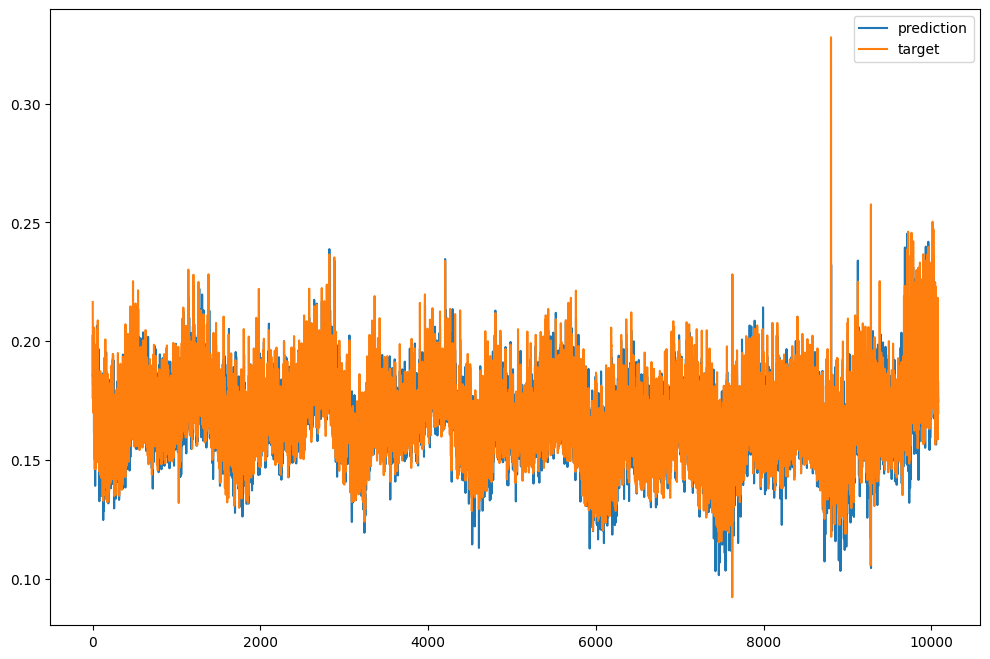

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.17623654, 0.20260245, 0.18516991, ..., 0.18324557, 0.1778899 ,
       0.17450163])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.785600885748863 %
RMSE 0.008839082904160023
MAPE 3.792954981327057 %


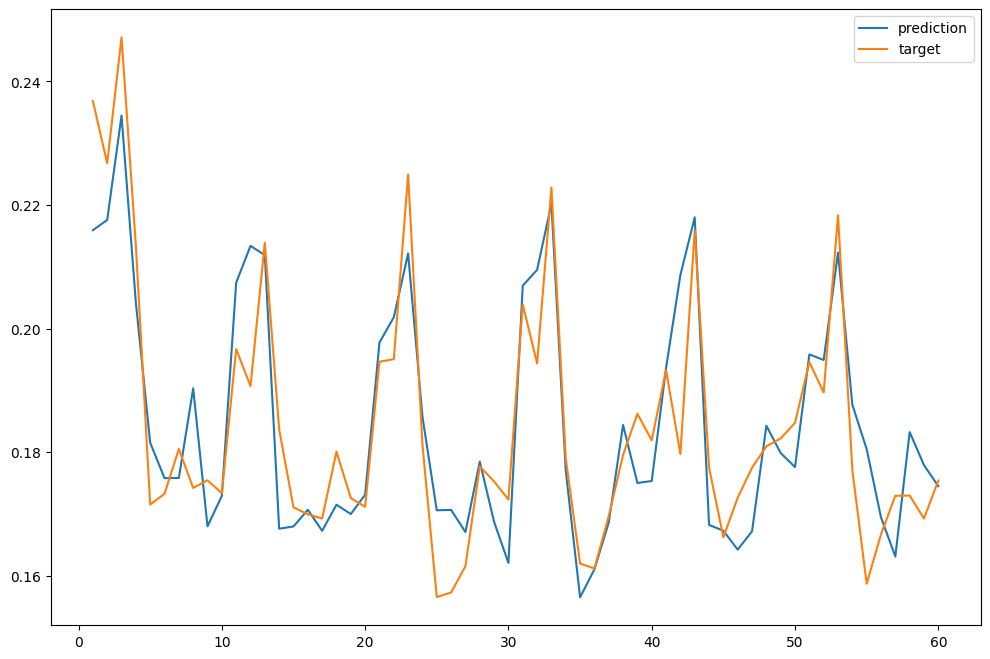

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.29087468548899603